## 1. Imports

In [79]:
%matplotlib notebook
import matplotlib.pyplot as plt

import pandas
import numpy as np
from scipy import signal
from datetime import timedelta
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter


## 2. Train set

In [70]:
import os
import sys

FREQ = 5
WINDOW = FREQ * 3

def preprocess_file(df):
    df['h_speed'] = (df['velN']**2 + df['velE']**2) ** 0.5 * 3.6
    df['v_speed'] = df['velD'] * 3.6
    df['h_speed'] = savgol_filter(df['h_speed'],
                                  WINDOW,
                                  0,
                                  mode='nearest')

    df['v_speed'] = savgol_filter(df['v_speed'],
                                  WINDOW,
                                  0,
                                  mode='nearest')

    return df
    
def train_dataset():
    from glob import glob

    directory = glob('../data/train/flight/*.csv')
    train_files = list()

    for name in directory:
        df = pandas.read_csv(name)
        df = preprocess_file(df)
        train_files.append(df)

    return pandas.concat(train_files)

   
dataset = train_dataset()
dataset = dataset.loc[dataset['class'].isin([2, 3])]
dataset['is_flight'] = (dataset['class'] == 2).astype('float')

features = ['h_speed', 'v_speed']
scaler = StandardScaler()
dataset[features] = scaler.fit_transform(dataset[features])

X_train = dataset[features]
y_train = dataset['is_flight']

## 3. Model parameters tuning

In [64]:
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(n_splits=5)

tuned_parameters = [{
    'kernel': ['rbf'],
    'gamma': [1.0, 10.0, 100.0],#, 0.001, 0.0001, 0.00001],
    'C': [0.1, 1, 10, 100, 1000]
}]
                    

print("# Tuning hyper-parameters for accuracy")

clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=kf,
                   scoring='accuracy', n_jobs=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()   

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:

{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on development set:

0.959 (+/-0.062) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.948 (+/-0.086) for {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
0.885 (+/-0.184) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.953 (+/-0.068) for {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}
0.937 (+/-0.092) for {'C': 1, 'gamma': 10.0, 'kernel': 'rbf'}
0.898 (+/-0.097) for {'C': 1, 'gamma': 100.0, 'kernel': 'rbf'}
0.949 (+/-0.076) for {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}
0.913 (+/-0.071) for {'C': 10, 'gamma': 10.0, 'kernel': 'rbf'}
0.883 (+/-0.093) for {'C': 10, 'gamma': 100.0, 'kernel': 'rbf'}
0.938 (+/-0.077) for {'C': 100, 'gamma': 1.0, 'kernel': 'rbf'}
0.903 (+/-0.065) for {'C': 100, 'gamma': 10.0, 'kernel': 'rbf'}
0.877 (+/-0.110) for {'C': 100, 'gamma': 100.0, 'kernel': 'rbf'}
0.936 (+/-0.082) for {'C': 1000, 'gamma': 1.0, 'kernel': 'rbf'}
0.887 (+/-0.090

## 4. Classifier training

In [71]:
svm_clf = svm.SVC(kernel='rbf', gamma=1, C=0.1)
svm_clf.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## 5. Model visualization

<IPython.core.display.Javascript object>


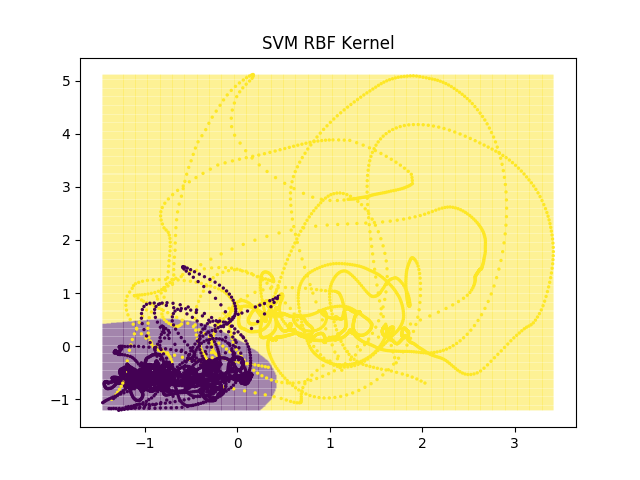

In [66]:
import numpy as np

plt.figure()
plt.scatter(X_train['h_speed'], X_train['v_speed'], c=dataset['is_flight'], zorder=10, s=2)

x_min, x_max = X_train['h_speed'].min(), X_train['h_speed'].max()
y_min, y_max = X_train['v_speed'].min(), X_train['v_speed'].max()

h = 0.01
XX, YY = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


Z = svm_clf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
ax = plt.gca()
ax.pcolormesh(XX, YY, Z, alpha = 0.1)

plt.title('SVM RBF Kernel')

plt.show()

## 5. Classifier testing

FLIGHT START: 2016-10-23 21:08:08.500000
AVG Speed before jump:  144.180401268
2016-10-23 21:10:03
FLIGHT END: 2016-10-23 21:10:03


<IPython.core.display.Javascript object>


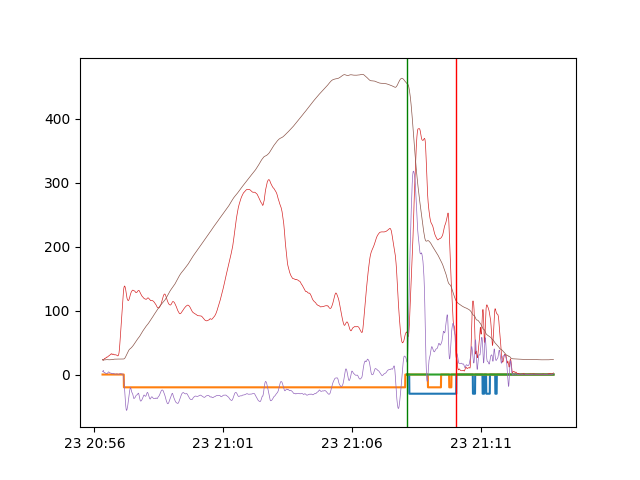

FLIGHT START: 2014-08-07 14:50:20.700000
AVG Speed before jump:  213.721975689
2014-08-07 14:52:04.800000
FLIGHT END: 2014-08-07 14:52:04.800000


<IPython.core.display.Javascript object>


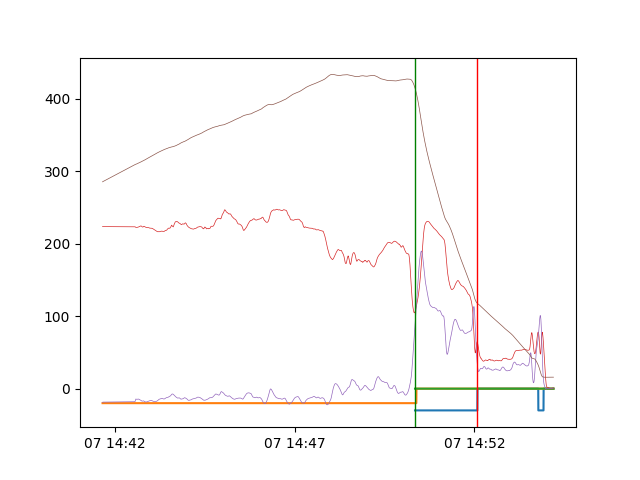

FLIGHT START: 2016-11-01 20:49:35.700000
AVG Speed before jump:  213.923752256
2016-11-01 20:51:38.800000
FLIGHT END: 2016-11-01 20:51:38.800000


<IPython.core.display.Javascript object>


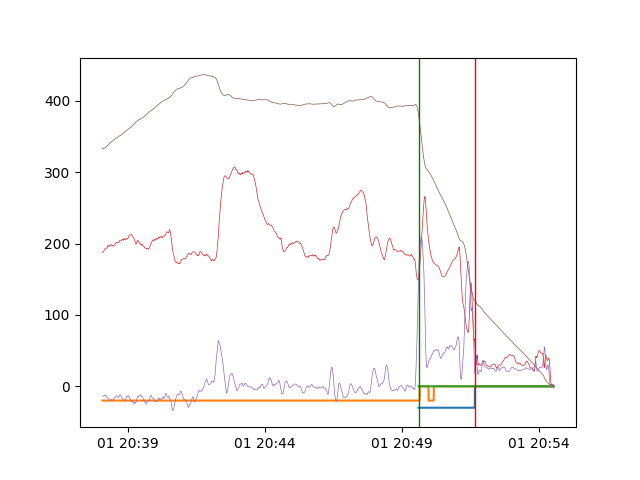

FLIGHT START: 2016-10-23 15:11:32.100000
AVG Speed before jump:  101.351844642
2016-10-23 15:12:55.200000
FLIGHT END: 2016-10-23 15:12:55.200000


<IPython.core.display.Javascript object>


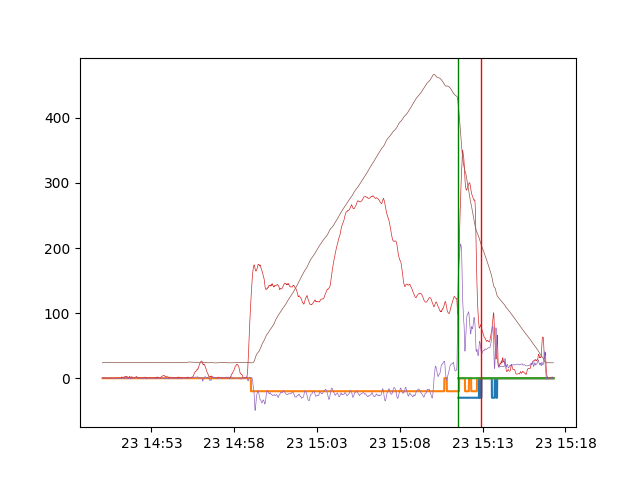

FLIGHT START: 2016-10-27 14:20:35.700000
AVG Speed before jump:  185.777080401
2016-10-27 14:23:55.600000
FLIGHT END: 2016-10-27 14:23:55.600000


<IPython.core.display.Javascript object>


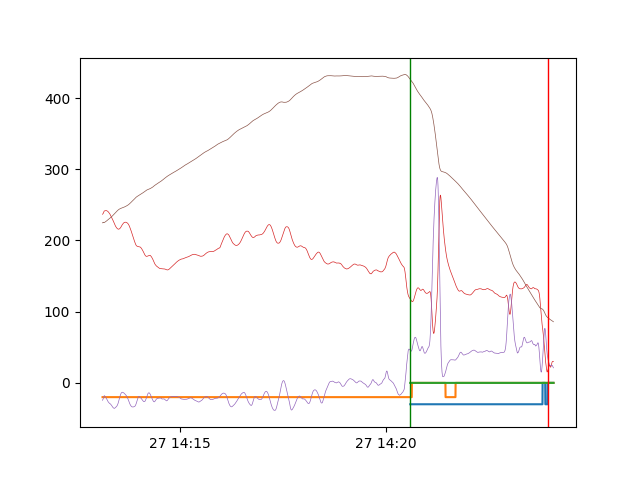

FLIGHT START: 2016-10-23 21:08:18.700000
AVG Speed before jump:  118.434309248
2016-10-23 21:11:09.800000
FLIGHT END: 2016-10-23 21:11:09.800000


<IPython.core.display.Javascript object>


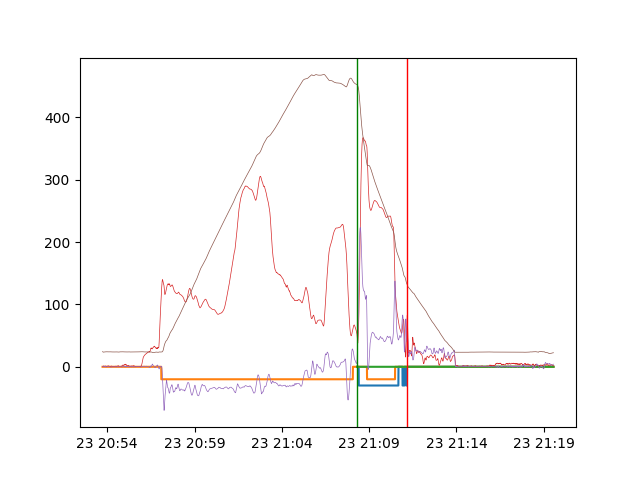

FLIGHT START: 2016-09-04 09:18:34.300000
AVG Speed before jump:  187.576202431
2016-09-04 09:19:50.600000
FLIGHT END: 2016-09-04 09:19:50.600000


<IPython.core.display.Javascript object>


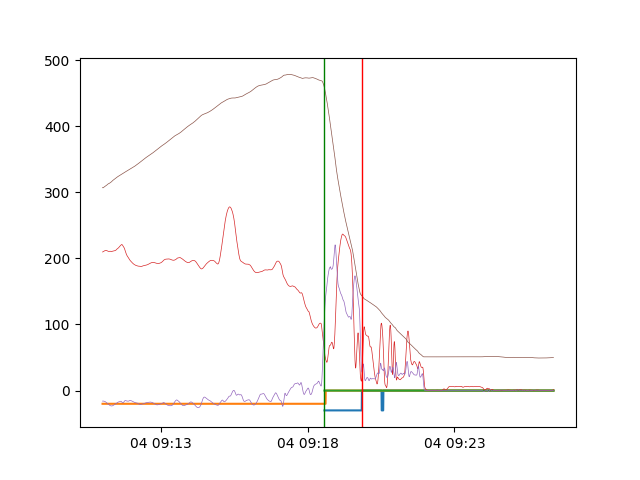

FLIGHT START: 2017-06-17 10:02:38.500000
AVG Speed before jump:  178.970462721
2017-06-17 10:04:41.400000
FLIGHT END: 2017-06-17 10:04:41.400000


<IPython.core.display.Javascript object>


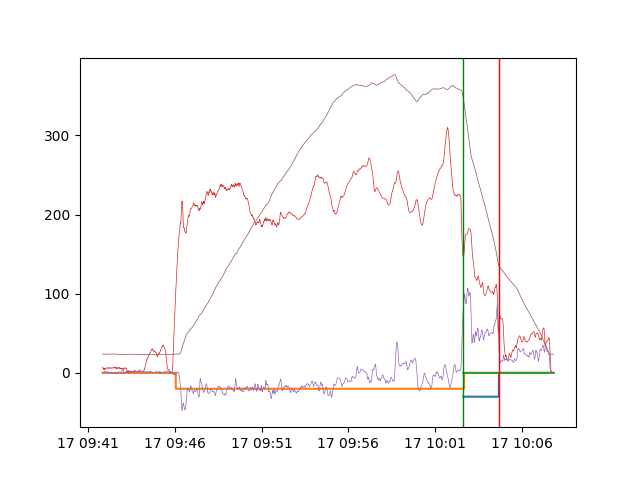

FLIGHT START: 2017-06-17 16:36:41.900000
AVG Speed before jump:  141.657509778
2017-06-17 16:38:39.800000
FLIGHT END: 2017-06-17 16:38:39.800000


<IPython.core.display.Javascript object>


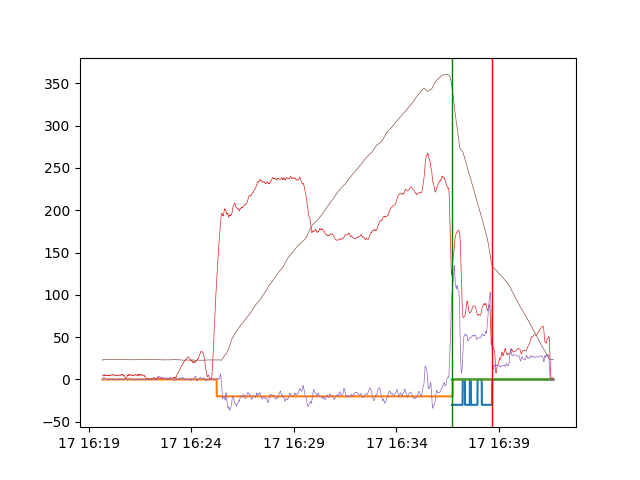

In [113]:
from sklearn.externals import joblib

def predict_and_show(filename):
    df = pandas.read_csv('../data/test/' + filename)
    df['time'] = pandas.to_datetime(df['time'])
    df['prev_time'] = df.shift()['time']
    df['time_diff'] = df['time'] - df['prev_time']

    most_used_freq = df['time_diff'].value_counts().index.values[0]
    freq = 1000 / most_used_freq.astype('timedelta64[ms]').astype('float')
    window_size = int(freq * 3)

    df.set_index('time', inplace=True)

    df['h_speed'] = (df['velN']**2 + df['velE']**2) ** 0.5 * 3.6
    df['v_speed'] = df['velD'] * 3.6

    df['h_speed'] = signal.savgol_filter(df['h_speed'], window_size, 0, mode='nearest')
    df['v_speed'] = signal.savgol_filter(df['v_speed'], window_size, 0, mode='nearest')
    
    df['gr'] = df['h_speed'] / df['v_speed']
    df['gr'] = df['gr'].replace([np.inf, -np.inf], np.nan).bfill()

    df['v_speed_chg_ms'] = (df['v_speed'] - df['v_speed'].shift(window_size).bfill()) * df['v_speed'].rolling(window='3s').mean().apply(lambda x: x > 25) 
    #df['v_speed_chg'] = df['v_speed_chg_ms'].rolling(window='3s').apply(lambda x: x[-1] - x[0])
    #df['v_acceleration'] = df['v_speed_chg_ms'] * (1000 / df['time_diff'].astype('timedelta64[ms]').astype('float'))

    aircr_clf = joblib.load('../model/aircraft.pkl')
    df['is_aircraft'] = aircr_clf.predict(df[['h_speed', 'v_speed', 'gr']])
    df['is_aircraft'] = df['is_aircraft'].rolling(window='15s').median()

    
    V_SPEED_THRESHOLD = 10 # m/s^2
    #df['flight_started'] = df['v_acceleration'].rolling(window='3s').mean().apply(lambda x: x > V_SPEED_THRESHOLD) & df['v_speed'].rolling(window='3s').mean().apply(lambda x: x > 25)
    #df['flight_started'] = df['v_speed_chg_ms'].apply(lambda x: x > V_SPEED_THRESHOLD)# & df['v_speed'].rolling(window='3s').mean().apply(lambda x: x > 25)
    V_SPEED_THRESHOLD = 30 # km/h
    df['flight_started'] = df['v_speed'].rolling(window='3s').mean().apply(lambda x: x > V_SPEED_THRESHOLD) & (df['is_aircraft'] == 0)
    
    orig = df.copy()
    flight_start = df['flight_started'].ne(False).idxmax() - timedelta(seconds=2.5)
    print('FLIGHT START:', flight_start)

    print('AVG Speed before jump: ', df[:flight_start]['h_speed'].mean())
    
    df = df[flight_start:]
    df[features] = scaler.transform(df[features])
    
    X_test = df[features]
    svm_clf = joblib.load('../model/flight.pkl')
    df['predicted_svm'] = svm_clf.predict(X_test)
    df['predicted_svm'] = df['predicted_svm'].rolling(window='5s').median()
    
    df['cl_weight'] =  np.where(df['predicted_svm'] == 1.0, 3.0, -1.0)
    df['weight'] = df['cl_weight'].cumsum()
    print(df['weight'].idxmax())
    #df['group'] = df['predicted_svm'].diff().ne(0).cumsum()
    
    def group_details(x):
        return pandas.Series({
            'class': x.iloc[1].predicted_svm, 
            'size': len(x.index),
            'segment_end': x.index[-1]
        })
        
#     segments = df.groupby('group').apply(group_details)
#     idx = segments[segments['class'] == 1.0]['size'].idxmax()
#     flight_end = segments.loc[idx].segment_end
    
    flight_end = df['predicted_svm'].eq(1).cumsum().idxmax()
    flight_end = df['weight'].idxmax()
    print('FLIGHT END:', flight_end)
    
   
    plt.figure()
    plt.plot(df['predicted_svm'] * -30)
    plt.plot(orig['is_aircraft'] * -20)
    plt.plot(df['flight_started'] * -0.05)
    plt.plot(orig['h_speed'], linewidth=0.5)
    plt.plot(orig['v_speed'], linewidth=0.5)
    plt.plot(orig['hMSL']/10, linewidth=0.5)    
    plt.axvline(x=flight_start, color='green', linewidth=1)    
    plt.axvline(x=flight_end, color='red', linewidth=1)


predict_and_show('#7990 15-56-18.CSV')
#predict_and_show('Skydive Med WS 2 labeled.csv')
#predict_and_show('#6294 17-15-08.CSV')

predict_and_show('#703 14-41-39.CSV')
predict_and_show('#8316 16-38-04.CSV')
predict_and_show('#7946 09-50-03.CSV')
predict_and_show('#8042 10-13-08.CSV')
predict_and_show('#8008 15-53-44.CSV')
predict_and_show('#7242 11-11-00.CSV')
predict_and_show('#RWL 13-41-49.CSV')
predict_and_show('#RWL 20-19-40.csv')
# predict_and_show('#RWL 17-16-43.csv')


plt.show()